In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import linalg
from matplotlib import animation

import time

sci_form = lambda x: np.format_float_scientific(x,precision=2)

#  Debye Length


### Define grid 

In [14]:
a=1e-6 #[m], 2a is size of cell, in 
N_x = int(1e2)
dx=2*a/N_x
#T=1 #s


x_list = np.linspace(-a,a,num=N_x)
#t_list = np.linspace(0,T,num=100)

### Define Parameters


In [15]:
eps0=8.85e-12
ee=1.6e-19  #Electron charge
me=9.1e-31  #Electron mass (kg)
mp=1.67e-27 #Proton mass (kg)

### Define 2-fluid equations

The equation for each species $\sigma$ should be 

$$  m n_\sigma \frac{D}{Dt} v_\sigma  = q_\sigma E n - \nabla P $$
$$   \left(\frac{\partial} {\partial t}+ v_\sigma \frac{\partial}{\partial x}\right) v_\sigma  = -(q/m)_\sigma \nabla\phi -\nabla P/(n_\sigma m_\sigma)$$
We also have continuity equation
$$ \left(\frac{\partial} {\partial t}+ v_\sigma \frac{\partial}{\partial x}\right) n=-n \frac{\partial}{\partial x}v$$

and separately we take
$$ -\nabla^2 \phi = \Sigma_\sigma q_\sigma n_\sigma/\epsilon_0, $$
$$ P = \Sigma_\sigma n_\sigma k_B T_\sigma$$



### Potential Solver

Before any plasma dynamics are found, we must first be able to solve for $\phi$ at every time step, relaxation method

$$\frac{d}{dx} \phi =\frac{\phi(x+dx/2)-\phi(x-dx/2)}{dx} $$
$$\frac{d^2}{dx^2} \phi =\frac{\phi(x+dx)-\phi(x) - \phi(x)+\phi(x-dx)}{dx^2} $$
$$\frac{d^2}{dx^2} \phi =\frac{\phi(x+dx)-2\phi(x)+ \phi(x-dx)}{dx^2} $$
or 
$$ \phi(x) = \frac{1}{2}\left( \Sigma_\sigma \rho(x)/\epsilon_0 +  \frac{\phi(x+dx)+ \phi(x-dx)}{dx^2}  \right)$$

## Boundary Conditions

Probably the only real motivated boundary condition here is the periodic one. Maybe potential could have Dirchlet, but let's make all periodic instead.
### It is crucial to note periodic spaces are *only* consistent if it is exactly neutral!!

In [223]:

#phi_0 = [0]*N_x #The phi at each point

def set_periodic(f):
    f=np.array(f)
    f[-1]=f[0]


def Jacobi_solver(a_p, a_m, b, tol=1e-3,dx_guess=None):
    if dx_guess==None:
        old_dx=np.zeros(len(a_p))
    else:
        old_dx=dx_guess
    dx=old_dx
    err=1
    i=0
   # fig, ax = plt.subplots()

    while err>tol:# and i<10:
        dx_p = shift_p(dx)
        dx_m = shift_m(dx)
        dx   = a_p*dx_p + a_m*dx_m + b

        try:
            err = max(abs(old_dx[np.where(dx!=0)]/dx[np.where(dx!=0)]-1))
        except ValueError:
            err=0
        old_dx=dx
       # lin=ax.plot(x_list,dx,label='{0}'.format(i))
        
        i+=1
    print("Showing plot")
    #plt.show()
    return dx


Debye length is 
$$\lambda_D^2 \approx v_{Th_e}^2 /\omega_e^2$$ 
$$\approx \frac{k_B T_e \epsilon_0}{q_e^2 n_e}$$
So the number of electrons within a Debye length (1-D) is:
$$N \approx n_e \lambda_D \approx \left(\frac{k_B T_e \epsilon_0 n_e}{q_e^2}\right)^{1/2}$$

dQ=0.00015999999999999999
Showing plot


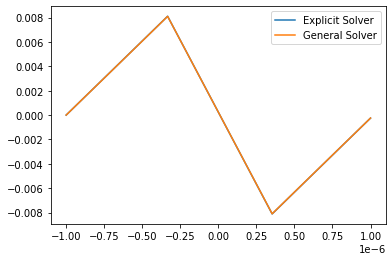

In [224]:
fig, ax  = plt.subplots()
rho=np.array(np.zeros(N_x)) #intialize rho over 1-D

dQ=ee*1e15
rho_0 = ee*1e20 # 1e-20 is ~ ITER density
print("dQ={0}".format(dQ))
rho[int(0.33*N_x)]=rho_0 
rho[int(0.67*N_x)] =-rho_0

tol=1e-10*(rho_0*a**2/eps0) #Tolerance should be less than roughly value of phi from expected charge 

phis_list=get_phi(rho,dx,tol=tol)[0]
for phis in phis_list:
    ax.plot(x_list,phis,label="Explicit Solver")
phis_list=[Jacobi_solver(0.5*np.ones(N_x),0.5*np.ones(N_x),0.5*rho/eps0*dx**2 ,tol=1e-5)]
for phis in phis_list:
    ax.plot(x_list,phis,label="General Solver")
plt.legend()


## Numeric Equations

$$   \left(\frac{\partial} {\partial t}+ v_\sigma \frac{\partial}{\partial x}\right) v_\sigma  = -(q/m)_\sigma \nabla\phi -\nabla P/(n_\sigma m_\sigma)$$
We also have continuity equation
$$ \left(\frac{\partial} {\partial t}+ v_\sigma \frac{\partial}{\partial x}\right) n=-n \frac{\partial}{\partial x}v$$



$$   dv_{\sigma}= dt \left(- v_\sigma \frac{\partial}{\partial x} v_\sigma - \left(\frac{q}{m}\right)_\sigma \nabla\phi -\nabla P/(n_\sigma m_\sigma)\right)$$

$$   dn_{\sigma}= - dt  \frac{\partial}{\partial x} (n_\sigma v_\sigma) $$

In [225]:
def grad(f):
    return (np.concatenate([f[1:],[f[0]]])-np.concatenate([[f[-1]],f[:-1]]))/(2*dx)

def periodify(x):
    return (x+a)%(2*a)-a
shift_p = lambda array: np.concatenate([array[1:], array[:1]]) 
shift_m = lambda array: np.concatenate([array[-1:], array[:-1]]) 


## Start trying implicit Euler?

Ignoring ion motion, the euqation for electron velocity is
$$dve=-dt*(ve*grad(ve,dx)-(ee/me)*grad(phi,dx)-T*(grad(ne,dx)/(ne*me)))# + grad(ni,dx)/(ni*mp)))$$, or 

$$\dot{v_e} = - v_e \nabla(v_e) - \frac{e}{m_e}\nabla(\phi) - \frac{T}{n_e m_e} \nabla(n_e) $$



is very difficult to solve. First consider only the first term, simple propagation of a disturbance.
$$ d v_e = - dt ve \nabla ve$$, which implicitly is
$$ v_e^{i+1}-v_e^{i} = - dt v_e^{i+1} \nabla v_e^{i+1} $$, which I have no idea how to solve even remotely efficiently
$$ dv_e = - dt (v_e + dv_e) \nabla (v_e+dv_e) $$
$$ dv_e \approx - dt (v_e \nabla v_e + dv_e \nabla v_e + v_e \nabla dv_e) + \mathcal{O}(dv_e^2) $$
Recall $ \nabla v_e^j = (2dx)^{-1} (v_e^{j+1}- v_e^{j-1})$ 

$$ dv_e^j (1 + dt(\nabla v_e)^j) + \frac{dt}{2dx}v_e^j(dv_e^{j+1}-dv_e^{j-1}) \approx - dt v^j_e (\nabla v_e)^j  $$
$$ A_{ij} dv_e^j \approx - dt (v_e \nabla v_e)^j  $$ which can be solved as a tri-diagonal matrix equation





Similarly, we have 
$$ dn_e^j = -dt\nabla((n_e+dn_e) v_e)^j $$
$$ dn_e^j(1+dt \nabla(v_e)^j) + \frac{dt }{2dx}v_e^j(dn_e^{j+1}-dn_e^{j-1}) = -dt\nabla(n_e v_e)^j $$

Notice we can think of things in terms of the material derivative, for instance
$$ \dot{n_e} = -\nabla(n_e v_e) $$
$$ \frac{D}{Dt}n_e = -n_e\nabla v_e $$
Then we simplify as
$$ dt \frac{D}{Dt}n_e^j= dn_e^j  + \frac{dt}{2 dx} v_e^j (n_e^{j+1}-n_e^{j-1})$$
No clear way to vastly simplify things ${\textit yet }$


#### Jacobi Method matrix solver
$$ dv_e^j = - dt v_e^j \left( \frac{(dv_e^{j+1}-dv_e^{j-1})}{2dx} + \nabla v_e^j \right)/(1 + dt(\nabla v_e)^j) $$
and
$$ dn_e^j = - dt  \left( v_e^j\frac{(dn_e^{j+1}-dn_e^{j-1})}{2dx} + \nabla( v_e^j n_e^j) \right)/(1 + dt(\nabla v_e)^j) $$
These have the form
$$ dx = a_p*x_p + a_m*x_m + b   $$

In [229]:
# Initialize grids
n0=1e20
ve=np.zeros(N_x,dtype=np.float128)
vi=np.zeros(N_x,dtype=np.float128)
ni=n0*np.ones(N_x,dtype=np.float128)
ne=n0*np.ones(N_x,dtype=np.float128)
#

T=1e4*ee # 1e3*ee is 1 keV in Joules
dt=1e-12 #seconds
N_step=1000
print("Total time: {0} s".format(sci_form(N_step*dt)))

#Test charge Gaussian
dn_A=1e4
dn_func = lambda A, x, x0, dn_sig: A*np.exp( -((periodify(x-x0))**2/dn_sig**2))
#print([dn_func(1e4, xi*dx-a, 0 , dx*10 ) for xi in range(len(ni))])

#Adding test charges
ni+= [dn_func(dn_A, xi*dx-a,0 , dx*10 ) for xi in range(len(ni))]
ne+= [dn_func(dn_A, xi*dx-a,0 , dx*10 ) for xi in range(len(ni))]

#print("Test charge density sigma={0} C/m^2".format(ni))#sci_form(ni*ee*dx)))
#print("Initial E field {0} V/m".format(sci_form(ni*ee*dx/eps0)))
#print("Initial acceleration {0} m/s^2".format(sci_form(ni*ee**2*dx/eps0/me)))
###

## Adding initial velocity 
ve+=1e4 #m/s
    
    
    
#Loop to solve
data=[ne-n0]
tol=1e-10*(ee*n0*a**2/eps0)
for ti in range(N_step):
    t0 = time.time()
    rho=ee*(ni-ne)
    phi=get_phi(rho,dx,max_iter=1e5,tol=tol)[0][0]
    
    #Solve implicit equation to first order for ve
    a_p = -dt*ve/(2*dx)/(1+dt*grad(ve))
    a_m = -a_p
    b   = -dt*ve*grad(ve)/(1+dt*grad(ve))
    #dve = Jacobi_solver(a_p,a_m,b)
    
    
    #Solve implicit equation to first order for ne
    a_p = -dt*ve/(2*dx)/(1+dt*grad(ve))
    a_m = -a_p
    b   = -dt*grad(ve*ne)/(1+dt*grad(ve))
    dne = Jacobi_solver(a_p,a_m,b,tol=1e-8)
    
    #update v,n. Does order matter?
    #ve+=dve
    ne+=dne
    data.append(ne-n0)
    print("[N_x, Elapsed time per time step [s]]=",[N_x,sci_form(time.time()-t0)])

    

Total time: 1.e-09 s
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '3.2e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.26e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.21e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.71e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.35e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.47e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.20e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.05e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.85e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.88e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.61e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.04e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.04e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.43e-03']


[N_x, Elapsed time per time step [s]]= [100, '2.78e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.84e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.07e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.91e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.07e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.20e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.04e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.09e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.02e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.56e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.02e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.99e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.47e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.10e-03']
Showing plot
[N_x, Elapsed time p

Showing plot
[N_x, Elapsed time per time step [s]]= [100, '2.16e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.72e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.30e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.64e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.24e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.2e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.68e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.50e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.10e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.05e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.46e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.59e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.05e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.08e-03']
Showing plot
[N_x, El

Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.1e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.14e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.07e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.2e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.21e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '6.88e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.61e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.92e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.95e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.4e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.32e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.78e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.44e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.7e-03']
Showing plot
[N_x, Elaps

Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.91e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.38e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.19e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.15e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.23e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.07e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.04e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '7.02e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.02e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.21e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.87e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.65e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '8.48e-04']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.82e-04']
Showing plot
[N_x, E

Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.07e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.72e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.04e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.17e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.26e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.26e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.48e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.16e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.37e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.69e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.69e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.37e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '1.21e-03']
Showing plot
[N_x, Elapsed time per time step [s]]= [100, '9.72e-04']
Showing plot
[N_x, E

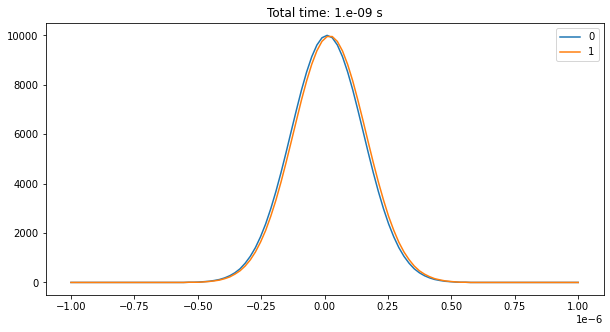

In [230]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_list,data[0],label='0')
ax.plot(x_list,data[1],label='1')
#ax.plot(x_list,data[2],label='2')
# ax.plot(x_list,data[3],label='3')
# ax.plot(x_list,data[int(N_step/3)],label='{0} s'.format(sci_form(int(N_step/3))))
# ax.plot(x_list,data[int(2*N_step/3)],label='{0} s'.format(sci_form(int(2*N_step/3))))
ax.set_title("Total time: {0} s".format(sci_form(N_step*dt)))
plt.legend()

In [ ]:
fig, ax = plt.subplots()
line, =plt.plot([],[])
fig.set_size_inches(5, 3, True)
ax.set_ylim(-dn_A,dn_A)
ax.set_xlim(-a,a)

def init():
    line.set_data([],[])#x_list,phi_list[0])
    return line,

def update(frame):
    line.set_data(x_list,data[frame])
    #print(data[frame])
    #ax.set_ylim(2*min(data[0]),2*max(data[0]))
    ax.set_title("{} s".format(sci_form(frame*dt)))
    return line,

anim= animation.FuncAnimation(fig,update,init_func=init,frames=N_step,interval=100,blit=True)
anim.save('basic_animation.mp4', fps=100, extra_args=['-vcodec', 'libx264'],dpi=500)

#### Initially stupid Euler method


In [16]:
class Particle()
    def __init__(self,m,q,name=''):
        self.m=m
        self.q=q
        self.name=name
    


class Plasma()
    def __init__(self,T):
        
        
    def P(self,x,t):
    
    def phi(self,x,t):
        
    
    
###############
"Rough code "

phi_i+1=
    

SyntaxError: invalid syntax (<ipython-input-16-25fe756320e0>, line 1)

In [ ]:
electron = Particle(0.511e6,-1,name="Elecron")
proton   = Particle(0.99e9,1,name="Proton")